# Alanine Dipeptide MD Simulation on WSL using AmberTools

This notebook automates the key steps from the **Amber "Simple Simulation of Alanine Dipeptide" tutorial** using AmberTools on Windows Subsystem for Linux (WSL)  
(derived from the official tutorial [“Simple Simulation of Alanine Dipeptide”](https://ambermd.org/tutorials/basic/tutorial0/)).

---

## Overview

- **What is simulated**  
  - A short explicit-solvent molecular dynamics (MD) simulation of **acetyl‑alanine‑N‑methylamide** (“ACE‑ALA‑NME”, a capped alanine dipeptide) in a solvated water box.
  - Follows a standard pipeline: *build → solvate → minimize → heat → production MD → analyze (e.g., RMSD)*.

- **Based on**  
  - The Amber tutorial originally built for Linux (Amber v20+), adapted here for **WSL/Ubuntu + AmberTools**, using **sander** (or optionally **pmemd**) as the MD engine.

---

## Notebook Structure

1. **System Setup**  
   Generate `tleap.in` to load FF19SB + water model, build the peptide, solvate, and save `parm7`/`rst7`.

2. **MD Input Preparation**  
   Write the three `.in` files based on tutorial:  
   - `01_Min.in` : energy minimization  
   - `02_Heat.in` : heating  
   - `03_Prod.in` : production run

3. **Running MD on WSL**  
   Execute minimization, heating, and production stages using `sander` (or `pmemd`), with proper use of relative directories.

4. **Analysis**  
   Automate trajectory analysis with `cpptraj` and visualize results: RMSD, energies, etc.
---

## Prerequisites

- WSL installed (Ubuntu recommended)
- `conda` environment with AmberTools (`ambertools25+`)
- `sander` (or `pmemd`) working in `$PATH`

## Codes

In [ ]:
import os
import subprocess
import time
from pathlib import Path, PurePosixPath
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import parmed
from shutil import copy2
import glob
import re
import pandas as pd
import seaborn as sns

### Functions

In [28]:
#=========UTILITY FUNCTIONS
def win_to_wsl_path(win_dir):
    win_dir = os.path.abspath(win_dir)
    drive, rest = win_dir[0], win_dir[2:]
    rest = rest.replace('\\', '/')
    return f"/mnt/{drive.lower()}{rest}"
#=========
def write_input_file(filename: str, content: str, win_dir: str):
    with open(Path(win_dir) / filename, "w", newline="\n") as f:
        f.write(content)
#=========
def run_wsl_command(command: str, wsl_dir: str, env_activate: str):
    full_cmd = f'wsl bash -c "mkdir -p \'{wsl_dir}\' && cd \'{wsl_dir}\' && {env_activate} && {command}"'
    print(f"Running: {full_cmd}")
    start = time.time()
    result = subprocess.run(full_cmd, shell=True, capture_output=True, text=True)
    elapsed = time.time() - start
    print(result.stdout)
    if result.stderr:
        print("STDERR:", result.stderr)
    print(f"#====> Command took {elapsed:.2f} seconds.\n")

In [ ]:
#========= STAGE 1: PREP (tleap)
def prepare_tleap(win_dir, wsl_dir, env_activate, sequence, unit_name, force_field = "protein.ff19SB", water = "tip3p", box = "TIP3PBOX", buffer_size = "10.0"):
    tleap_input = f"""
    source leaprc.{force_field}
    source leaprc.water.{water}
    {unit_name} = sequence {{ {sequence} }}
    solvateoct {unit_name} {box} {buffer_size}
    saveamberparm {unit_name} parm7 rst7
    quit
    """
    write_input_file("tleap.in", tleap_input, win_dir)
    run_wsl_command("tleap -f tleap.in", wsl_dir, env_activate)

#========= STAGE 2: WRITE MD INPUTS
def write_mdins(win_dir, minimization_params, heating_params, production_params):
    mdin_files = {
        "01_Min.in": minimization_params,
        "02_Heat.in": heating_params,
        "03_Prod.in": production_params
    }

    for fname, content in mdin_files.items():
        write_input_file(fname, content, win_dir)
#========= STAGE 3: RUN MD STEPS
def run_md(win_dir, wsl_dir, env_activate, use_pmemd=False):
    engine = "pmemd" if use_pmemd else "sander"
    run_wsl_command(f"{engine} -O -i 01_Min.in -o 01_Min.out -p parm7 -c rst7 -r 01_Min.ncrst -inf 01_Min.mdinfo", wsl_dir, env_activate)
    run_wsl_command(f"{engine} -O -i 02_Heat.in -o 02_Heat.out -p parm7 -c 01_Min.ncrst -r 02_Heat.ncrst -x 02_Heat.nc -inf 02_Heat.mdinfo", wsl_dir, env_activate)
    run_wsl_command(f"{engine} -O -i 03_Prod.in -o 03_Prod.out -p parm7 -c 02_Heat.ncrst -r 03_Prod.ncrst -x 03_Prod.nc -inf 03_Prod.mdinfo", wsl_dir, env_activate)

#========= STAGE 4: ANALYSIS WITH CPPTRAJ
def run_cpptraj(win_dir, wsl_dir, env_activate):
    cpptraj_script = """trajin 02_Heat.nc
trajin 03_Prod.nc
reference 01_Min.ncrst
autoimage
center :1-3 mass origin
image origin center
rms reference mass out 02_03.rms time 2.0 :2
"""
    write_input_file("rmsd.cpptraj", cpptraj_script, win_dir)
    run_wsl_command("cpptraj -p parm7 -i rmsd.cpptraj", wsl_dir, env_activate)

#========= MASTER FUNCTION
def run_all(win_dir, wsl_dir, env_activate, sequence, unit_name, minimization_params, heating_params, production_params, use_pmemd=False):
    prepare_tleap(win_dir, wsl_dir, env_activate, sequence, unit_name)
    write_mdins(win_dir, minimization_params, heating_params, production_params)
    run_md(win_dir, wsl_dir, env_activate, use_pmemd)
    run_cpptraj(win_dir, wsl_dir, env_activate)
    print("#====> All steps completed.")
#=========

In [ ]:
#===== post-processing codes
def parse_full_md_output(file_path):
    data = []
    with open(file_path, "r") as f:
        lines = f.readlines()
    current = {}
    for line in lines:
        if "NSTEP" in line and "TIME(PS)" in line:
            match = re.search(r"NSTEP\s*=\s*(\d+)\s+TIME\(PS\)\s*=\s*([-\d.]+)\s+TEMP\(K\)\s*=\s*([-\d.]+)\s+PRESS\s*=\s*([-\d.]+)", line)
            if match:
                current = {
                    "NSTEP": int(match.group(1)),
                    "Time_ps": float(match.group(2)),
                    "Temperature_K": float(match.group(3)),
                    "Pressure": float(match.group(4))
                }
        elif "Etot" in line:
            match = re.search(r"Etot\s*=\s*([-\d.]+)\s+EKtot\s*=\s*([-\d.]+)\s+EPtot\s*=\s*([-\d.]+)", line)
            if match:
                current.update({
                    "Etot": float(match.group(1)),
                    "EKtot": float(match.group(2)),
                    "EPtot": float(match.group(3)),
                })
        elif "BOND" in line:
            match = re.search(r"BOND\s*=\s*([-\d.]+)\s+ANGLE\s*=\s*([-\d.]+)\s+DIHED\s*=\s*([-\d.]+)", line)
            if match:
                current.update({
                    "BOND": float(match.group(1)),
                    "ANGLE": float(match.group(2)),
                    "DIHED": float(match.group(3)),
                })
        elif "1-4 NB" in line:
            match = re.search(r"1-4 NB\s*=\s*([-\d.]+)\s+1-4 EEL\s*=\s*([-\d.]+)\s+VDWAALS\s*=\s*([-\d.]+)", line)
            if match:
                current.update({
                    "1-4 NB": float(match.group(1)),
                    "1-4 EEL": float(match.group(2)),
                    "VDWAALS": float(match.group(3)),
                })
        elif "EELEC" in line:
            match = re.search(r"EELEC\s*=\s*([-\d.]+)\s+EHBOND\s*=\s*([-\d.]+)\s+RESTRAINT\s*=\s*([-\d.]+)", line)
            if match:
                current.update({
                    "EELEC": float(match.group(1)),
                    "EHBOND": float(match.group(2)),
                    "RESTRAINT": float(match.group(3)),
                })
        elif "EKCMT" in line:
            match = re.search(r"EKCMT\s*=\s*([-\d.]+)\s+VIRIAL\s*=\s*([-\d.]+)\s+VOLUME\s*=\s*([-\d.]+)", line)
            if match:
                current.update({
                    "EKCMT": float(match.group(1)),
                    "VIRIAL": float(match.group(2)),
                    "VOLUME": float(match.group(3)),
                })
        elif "CMAP" in line:
            match = re.search(r"CMAP\s*=\s*([-\d.]+)", line)
            if match:
                current["CMAP"] = float(match.group(1))
        elif "Density" in line:
            match = re.search(r"Density\s*=\s*([-\d.]+)", line)
            if match:
                current["Density"] = float(match.group(1))
                data.append(current)  # Complete record collected
    df = pd.DataFrame(data)
    return df
#========
def plot_rmsd(win_dir):
    rmsd_path = Path(win_dir) / "02_03.rms"
    if not rmsd_path.exists():
        print("RMSD file not found. Run cpptraj first.")
        return
    data = np.loadtxt(rmsd_path, comments="#")
    time, rmsd = data[:, 0], data[:, 1]
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    plt.plot(time, rmsd, color="steelblue", lw=2.2, label="RMSD")
    plt.xlabel("Time (ps)", fontsize=12)
    plt.ylabel("RMSD (Å)", fontsize=12)
    plt.title("Alanine Dipeptide RMSD Over Time", fontsize=14, weight='bold')
    plt.legend(frameon=False, fontsize=10)
    plt.tight_layout()
    plt.show()
#========
def extract_phi_psi(win_dir, wsl_dir, env_activate):
    """Create cpptraj script to extract phi and psi angles."""
    cpptraj_script = """trajin 03_Prod.nc
    dihedral phi :1@C :2@N :2@CA :2@C out phi.dat
    dihedral psi :2@N :2@CA :2@C :3@N out psi.dat
    """
    write_input_file("dihedrals.cpptraj", cpptraj_script, win_dir)
    run_wsl_command("cpptraj -p parm7 -i dihedrals.cpptraj", wsl_dir, env_activate)
#========
def plot_phi_psi(win_dir):
    """Plot phi/psi time series and Ramachandran-like scatter plot."""
    phi_path = Path(win_dir) / "phi.dat"
    psi_path = Path(win_dir) / "psi.dat"
    if not phi_path.exists() or not psi_path.exists():
        print("phi.dat or psi.dat not found. Run extract_phi_psi() first.")
        return

    phi = np.loadtxt(phi_path, comments=["#", "@"])
    psi = np.loadtxt(psi_path, comments=["#", "@"])

    plt.figure(figsize=(12, 4))
    # Plot phi/psi over time
    plt.subplot(1, 2, 1)
    plt.plot(phi[:, 0], phi[:, 1], label='phi')
    plt.plot(psi[:, 0], psi[:, 1], label='psi')
    plt.xlabel("Time (ps)")
    plt.ylabel("Angle (°)")
    plt.title("Phi/Psi Time Series")
    plt.legend()
    # Ramachandran-like scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(phi[:, 1], psi[:, 1], alpha=0.6, s=10)
    plt.xlabel("Phi (°)")
    plt.ylabel("Psi (°)")
    plt.title("Phi vs Psi")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
#========
def show_trajectory(win_dir):

    topology_file = Path(win_dir) / "parm7"
    traj_file = Path(win_dir) / "03_Prod.nc"

    if not topology_file.exists() or not traj_file.exists():
        print("Missing topology or trajectory file. Run MD simulations first.")
        return
    structure = parmed.load_file(str(topology_file), str(traj_file))
    view = nv.show_parmed(structure)
    view.add_representation("cartoon", selection="all")
    view.center()
    view._remote_call("setParameters", target="stage.player", args=[{"step": 1, "delay": 10}])
    view._remote_call("play", target="stage.player")
    return view

#=======
def export_snapshot(view, filename="frame.png"):
    view.download_image(filename=filename, factor=4, antialias=True)
    print(f"Snapshot saved as {filename}")
#=======
def convert_pymol(wsl_dir, env_activate):
    cpptraj_script = """
    trajin 03_Prod.nc
    trajout traj.pdb
    """
    write_input_file("export_traj.cpptraj", cpptraj_script, wsl_dir)
    run_wsl_command("cpptraj -p parm7 -i export_traj.cpptraj", wsl_dir, env_activate)
#========
def plot_md_summary(df: pd.DataFrame):

    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    # Temperature
    axs[0].plot(df["Time_ps"], df["Temperature_K"], label="Temperature", color="firebrick")
    axs[0].set_ylabel("Temperature (K)")
    axs[0].set_title("MD Simulation Summary")
    axs[0].legend()
    axs[0].grid(True)
    # Density
    axs[1].plot(df["Time_ps"], df["Density"], label="Density", color="seagreen")
    axs[1].set_ylabel("Density (g/cm^3)")
    axs[1].legend()
    axs[1].grid(True)
    # Energies
    axs[2].plot(df["Time_ps"], df["Etot"], label="Total Energy", color="navy")
    axs[2].plot(df["Time_ps"], df["EKtot"], label="Kinetic Energy", color="orange")
    axs[2].plot(df["Time_ps"], df["EPtot"], label="Potential Energy", color="darkgreen")
    axs[2].set_xlabel("Time (ps)")
    axs[2].set_ylabel("Energy (kcal/mol)")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
#========

### Scripts

In [ ]:
#========
#set params
#========
project_name = 'alanine_md'
workdir_win = rf'./{project_name}'
workdir_wsl = win_to_wsl_path(os.path.abspath(workdir_win))
os.makedirs(workdir_win, exist_ok=True)
env_activate = "source ~/miniconda3/etc/profile.d/conda.sh && conda activate AmberTools25"

sequence = "ACE ALA NME"
unit_name = "diala"
#========
#========
minimization_params = """Minimize
&cntrl
 imin=1, ntx=1, irest=0,
 maxcyc=2000, ncyc=1000,
 ntpr=100, ntwx=0,
 cut=8.0,
/
"""
#========
heating_params = """Heat
&cntrl
 imin=0, ntx=1, irest=0,
 nstlim=10000, dt=0.002,
 ntf=2, ntc=2,
 tempi=0.0, temp0=300.0,
 ntpr=100, ntwx=100,
 cut=8.0, ntb=1, ntp=0,
 ntt=3, gamma_ln=2.0,
 nmropt=1, ig=-1,
/
&wt type='TEMP0', istep1=0, istep2=9000, value1=0.0, value2=300.0 /
&wt type='TEMP0', istep1=9001, istep2=10000, value1=300.0, value2=300.0 /
&wt type='END' /
"""
#========
production_params = """Production
&cntrl
 imin=0, ntx=5, irest=1,
 nstlim=5000000, dt=0.002,
 ntf=2, ntc=2,
 temp0=300.0,
 ntpr=100, ntwx=100,
 cut=8.0, ntb=2, ntp=1,
 ntt=3, barostat=1,
 gamma_ln=2.0, ig=-1,
/
"""
#========

In [ ]:
#===== Run full MD pipeline
run_all(workdir_win, workdir_wsl, env_activate, sequence, unit_name, 
        minimization_params, heating_params, production_params, 
        use_pmemd=False)  # set True if you have pmemd
#=====

Running: wsl bash -c "mkdir -p '/mnt/c/Users/mehr/Documents/md_project/alanine_md_2' && cd '/mnt/c/Users/mehr/Documents/md_project/alanine_md_2' && source ~/miniconda3/etc/profile.d/conda.sh && conda activate AmberTools25 && tleap -f tleap.in"
-I: Adding /home/m/miniconda3/envs/AmberTools25/dat/leap/prep to search path.
-I: Adding /home/m/miniconda3/envs/AmberTools25/dat/leap/lib to search path.
-I: Adding /home/m/miniconda3/envs/AmberTools25/dat/leap/parm to search path.
-I: Adding /home/m/miniconda3/envs/AmberTools25/dat/leap/cmd to search path.
-f: Source tleap.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap.in
----- Source: /home/m/miniconda3/envs/AmberTools25/dat/leap/cmd/leaprc.protein.ff19SB
----- Source of /home/m/miniconda3/envs/AmberTools25/dat/leap/cmd/leaprc.protein.ff19SB done
Log file: ./leap.log
Loading parameters: /home/m/miniconda3/envs/AmberTools25/dat/leap/parm/parm19.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA + ff19S

### Post-processing

In [ ]:
#===== Load results
prod_out_path = Path(workdir_win) / "03_Prod.out"
df = parse_full_md_output(prod_out_path)


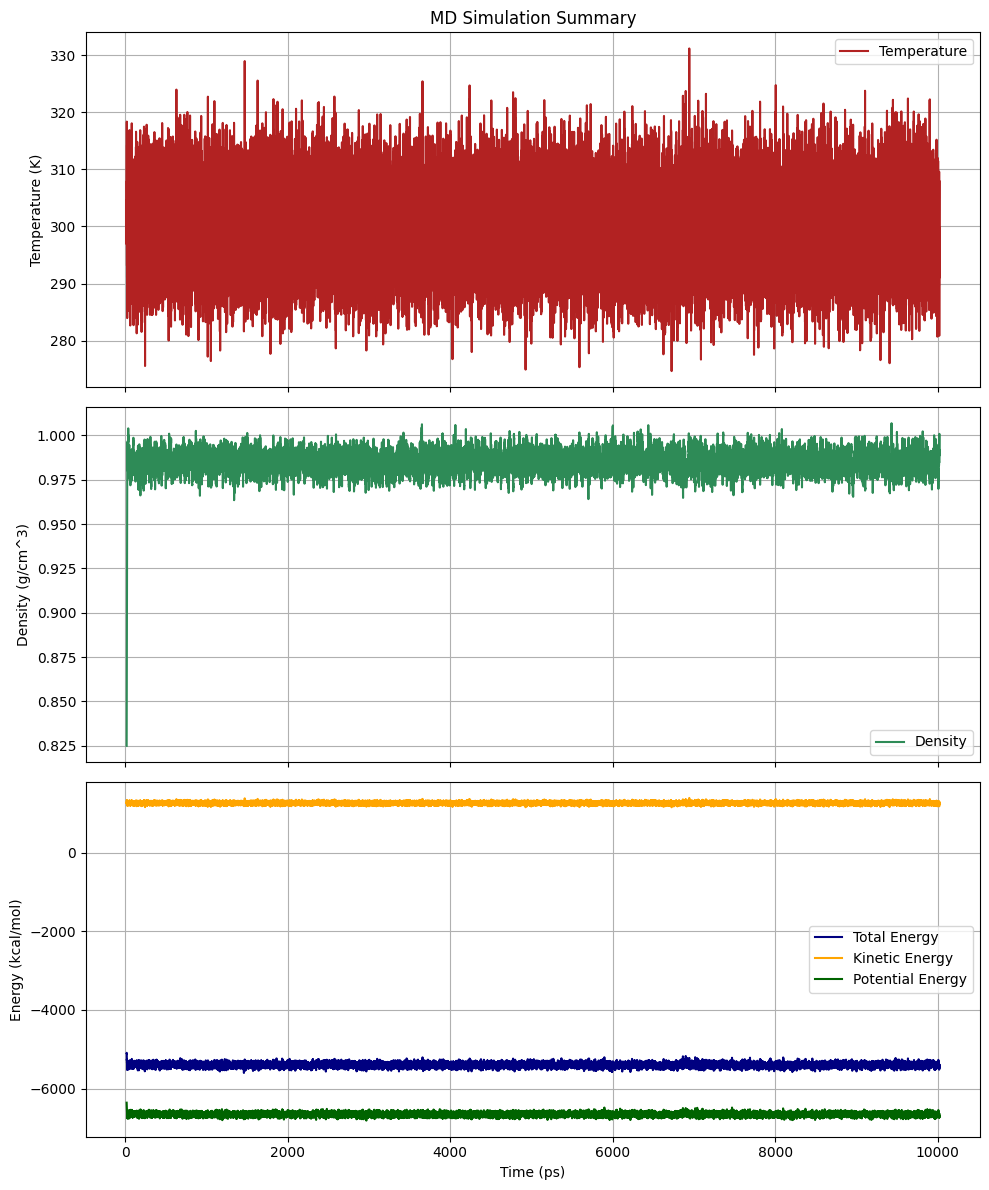

In [ ]:
#===== Plot Density, Temperature, Energy
plot_md_summary(df.iloc[:-1])

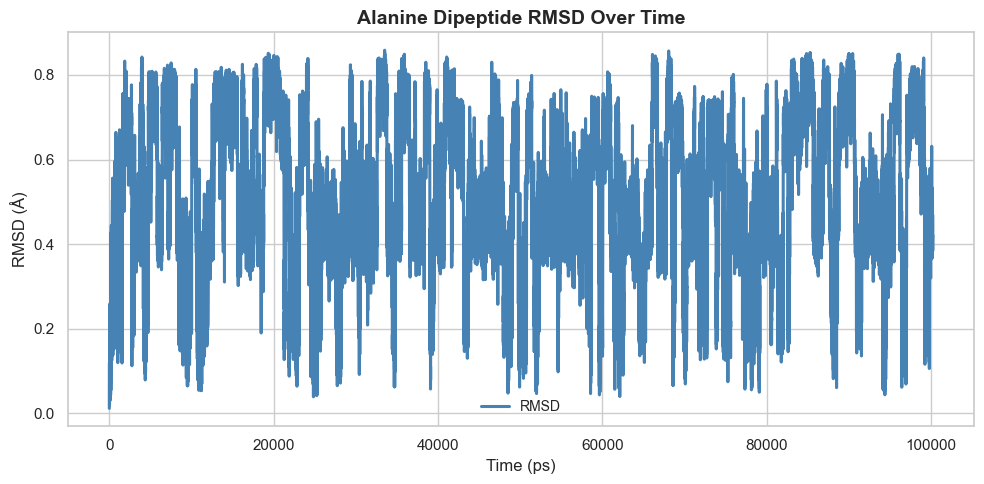

In [ ]:
#===== Plot RMSD 
plot_rmsd(workdir_win)               


Running: wsl bash -c "mkdir -p '/mnt/c/Users/mehr/Documents/md_project/alanine_md_2' && cd '/mnt/c/Users/mehr/Documents/md_project/alanine_md_2' && source ~/miniconda3/etc/profile.d/conda.sh && conda activate AmberTools25 && cpptraj -p parm7 -i dihedrals.cpptraj"

CPPTRAJ: Trajectory Analysis. V6.18.1 (AmberTools)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 06/12/25 21:16:56
| Available memory: 24.013 GB

	Reading 'parm7' as Amber Topology
	Radius Set: modified Bondi radii (mbondi)
INPUT: Reading input from 'dihedrals.cpptraj'
  [trajin 03_Prod.nc]
	Reading '03_Prod.nc' as Amber NetCDF
  [dihedral phi :1@C :2@N :2@CA :2@C out phi.dat]
    DIHEDRAL: [:1@C]-[:2@N]-[:2@CA]-[:2@C]
              Output range is -180 to 180 degrees.
  [dihedral psi :2@N :2@CA :2@C :3@N out psi.dat]
    DIHEDRAL: [:2@N]-[:2@CA]-[:2@C]-[:3@N]
              Output range is -180 to 180 degrees.
---------- RUN BEGIN -------------------------------------------------

PARAMETE

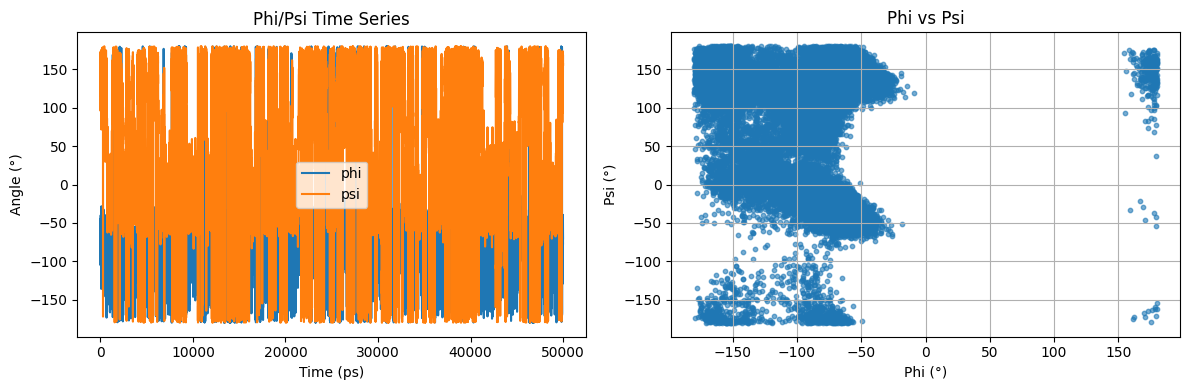

In [ ]:
#===== Plot phi psi
extract_phi_psi(workdir_win, workdir_wsl, env_activate)         # Generate φ/ψ data
plot_phi_psi(workdir_win)            # Plot φ/ψ series + scatter

In [ ]:
#===== Traj Animation
view = show_trajectory(workdir_win)
view

NGLWidget(max_frame=49999)

In [ ]:
#===== 
export_snapshot(view, filename="frame.png")

Snapshot saved as frame.png
